# Week 8 Acceleration algorithm 

#  Loading data

In [1]:
%pylab inline
from pysptools import abundance_maps
import random
import pandas as pd
import urllib
import itertools
from scipy.io import loadmat
from scipy.signal import convolve2d

Populating the interactive namespace from numpy and matplotlib


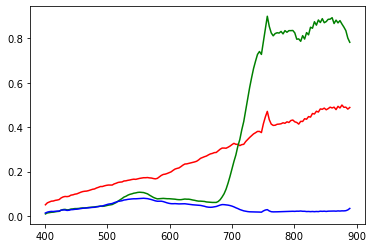

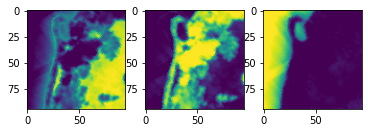

In [2]:
dataset = "samson"

d = loadmat("../input/reference-datasets/" + dataset + "/" + dataset + ".mat")
em = loadmat("../input/reference-datasets/" + dataset + "/endmembers/endmembers.mat")
dinfo = pd.read_csv("../input/reference-datasets/" + dataset + "/info.csv",header=None,index_col=None,names=["parameter",'value','unit'])

nrow = int(dinfo[dinfo['parameter'] == 'nrow'].value.values[0])
ncol = int(dinfo[dinfo['parameter'] == 'ncol'].value.values[0])

nbands = int(dinfo[dinfo['parameter'] == 'nbands'].value.values[0])
spec_start = dinfo[dinfo['parameter'] == 'spec_start'].value.values[0]
spec_end = dinfo[dinfo['parameter'] == 'spec_end'].value.values[0]

data = d['Y']
data = data / data.max()
try:
    spec_bands = d['SlectBands'].flatten()
except:
    spec_bands = arange(0,nbands)

# Define wavelength array
wavelength = linspace(spec_start,spec_end,nbands)
wavelength = wavelength[spec_bands]

if len(em['M']) > len(wavelength):
    endmembers = em['M'][spec_bands]
else:
    endmembers = em['M']

endmembers = endmembers.reshape(len(wavelength),-1)

a_map = em["A"].reshape((endmembers.shape[1],nrow,ncol)).T

hypercube = data.copy()
spectra = endmembers.T
hypercube = hypercube.reshape(len(wavelength), a_map.shape[1], a_map.shape[0]).T

# it is found the endmembers' spectra are normalised to 1, which is not the real spectra
# for the original spectra, see paper:
# Zhu, 2017, Hyperspectral Unmixing: Ground Truth Labeling, Datasets, Benchmark Performances and Survey.
spectra[0] = spectra[0] * 0.5
spectra[1] = spectra[1] * 0.9
spectra[2] = spectra[2] * 0.08

figure(1)
plot(wavelength, spectra[0], color='r')
plot(wavelength, spectra[1], color='g')
plot(wavelength, spectra[2], color='b')
plt.show()

figure(2)
subplot(1,3,1)
imshow(a_map[:,:,0])
subplot(1,3,2)
imshow(a_map[:,:,1])
subplot(1,3,3)
imshow(a_map[:,:,2])

# Give the prediected unmixing reslut

In [3]:
def compute_unmixing_accuracy(hypercube, abundance_map, endmembers, wavelength, center_wavelengths, bandwidths, return_predicted=False):
    '''
    Function to compute unmixing accuracy using NNLS spectral unmixing given a set of spectral band 
    center wavelengths and bandwidths. Assuming gaussian filter responses with a bandwidth defined
    as the FWHM.
    
    Inputs:
        hypercube (N X M x Q) - 3D synthetic hypercube.
        
        abundance_map (N x M x P)- 3D ground-truth abundance map of target. Each channel in L corresponds to the
             abundance (between 0 and 1) of the spectral signature in the spectra array. 
        
        endmembers (P x Q array) - Array of endmember signals to unmix.
        
        wavelength (1 x Q array) - Array describing the wavelength value corresponding to the spectral
            response arrays.
        
        center_wavelengths (1 x L array) - Array or list of center wavelengths for Gaussian filter responses
            to use for unmixing.
        
        bandwidths (1 x L array) - Array or list of bandwidths for Gaussian filter responses
            to use for unmixing.
        
    Outputs:
        accuracy (float) - RMS error of the unmixed abundance compared to the gruond truth
        
        predicted (optional N x M x P array) - Predicted abundance map of hypercube
    '''
    # Extract relevant dimensions
    N,M,Q = hypercube.shape
    
    # Define filter responses
    filters = [exp(-(wavelength - center_wavelengths[i])**2 / (2*(bandwidths[i]/2.355)**2)) for i in range(len(center_wavelengths))]
    
    P = len(endmembers)
    L = len(filters)
    
    # Pre-allocate arrays
    data_sig = zeros((N*M,L))
    endmember_sig = zeros((P,L))
    
    # Iterate through each filter
    for i,f in enumerate(filters):
        # Compute the signal from each filter received from the data
        # and that received from an endmember.
        data_sig[:,i] = sum(hypercube.reshape((N*M,Q))*f,axis=1) # (N*M) x L
        
        for j, e in enumerate(endmembers):
            endmember_sig[j,i] = sum(endmembers[j]*f) # P x Q
            
    # Reshape the data array into 1d array
    predicted = abundance_maps.amaps.NNLS(data_sig, endmember_sig) # (N*M x P)

    # Take RMS difference between true abundance map and computed.
    accuracy = sqrt(mean((abundance_map.reshape((N*M,len(endmember_sig)))-predicted)**2))
    
    print('acc = ',accuracy)
    if not accuracy or isnan(accuracy):
        return 100.
    
    if return_predicted:
        return accuracy, predicted.reshape((N,M,P))
    else:
        return accuracy

In [4]:
N,M,P = hypercube.shape

# Mean removal algorithm

In [5]:
N 

95

Samiliar to normalization,already done in samson dataset, double check here

In [6]:
sqrt(mean(hypercube**2))

0.24432258768506898

In [7]:
hypercube = hypercube/sqrt(mean(hypercube**2))

In [8]:
l = 0.2
T = 2
U = 1

# Now, take Sobel operator to detect discontinuities in the gradient

In [9]:
def sobel(img, threshold):
    '''
    edge detection based on sobel
    threshold (0,1)
    '''
    G_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    G_y = np.array([[-1, -2, -1],[0, 0, 0],[1, 2, 1]])
    rows = np.size(img, 0)
    columns = np.size(img, 1)
    mag = np.zeros(img.shape)
    for i in range(0, rows - 2):
        for j in range(0, columns - 2):
            v = sum(sum(G_x * img[i:i+3, j:j+3]))  # vertical
            h = sum(sum(G_y * img[i:i+3, j:j+3]))  # horizon
            mag[i+1, j+1] = np.sqrt((v ** 2) + (h ** 2))
            
    for p in range(0, rows):
        for q in range(0, columns):
            if mag[p, q] < threshold:
                mag[p, q] = 0
    return mag

In [10]:
hypercube.shape[2]

156

In [11]:
sober_img = np.zeros(hypercube.shape)

for i in range(hypercube.shape[2]):
    sober_img[:,:,i] = sobel(hypercube[:,:,i], l)

# dirty tiles

In [12]:
def tiles (img, t, u):
    '''
    t = tile_size
    u: percentage_of_edge_pixels
    '''
    rows = np.size(img, 0)
    columns = np.size(img, 1)
    mag = np.zeros(img.shape)
    sub_area = np.zeros((t,t))      
    for p in range(0, rows):
        for q in range(0, columns):
            sub_area = img[p:p+t,q:q+t]
            area_sum = sum(sub_area)
            if area_sum > t*t*u:
                mag[p, q] = 1
    return mag

In [13]:
tiles_img = np.zeros(hypercube.shape)

for i in range(hypercube.shape[2]):
    tiles_img[:,:,i] = tiles(sober_img[:,:,i],T,U)

Text(0.5, 1.0, 'dirty tiles')

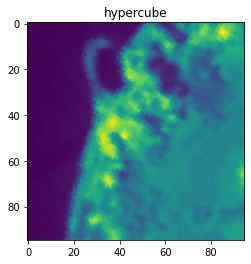

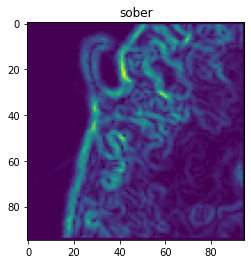

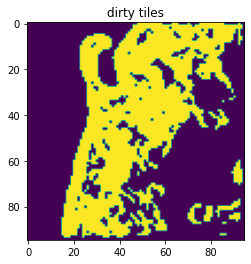

In [14]:
figure(1)
imshow(hypercube [:,:,150])
title('hypercube')


figure(2)
imshow(sober_img [:,:,150])
title('sober')

figure(3)
imshow(tiles_img [:,:,150])
title('dirty tiles')


# Now use the pre-procesing hypercube to get the unmixing result 

In [15]:
predicted_origin = abundance_maps.amaps.NNLS(hypercube.reshape((N*M,P)), spectra) # (N*M x P)
accuracy_origin = sqrt(mean((a_map.reshape((N*M,len(spectra)))-predicted_origin)**2))


predicted_sober = abundance_maps.amaps.NNLS(sober_img.reshape((N*M,P)), spectra) # (N*M x P)
accuracy_sober = sqrt(mean((a_map.reshape((N*M,len(spectra)))-predicted_sober)**2))


predicted_tiles = abundance_maps.amaps.NNLS(tiles_img.reshape((N*M,P)), spectra) # (N*M x P)
accuracy_tiles = sqrt(mean((a_map.reshape((N*M,len(spectra)))-predicted_tiles)**2))

In [16]:
accuracy_origin 

1.2624161724274319

In [17]:
accuracy_sober

3.1166341460235483

In [18]:
accuracy_tiles

1.0442839520867624

Now consider color fulter array, original

In [19]:
opti_wavelength_1 = [528., 684., 760.]
opti_wavelength_2 = [613, 565, 891]

opti_bw = [20,20,20]

Now consider color fulter array, tiles

In [21]:
acc2,map2 = compute_unmixing_accuracy(tiles_img, a_map, spectra, wavelength, opti_wavelength_1, opti_bw, return_predicted=True)

acc =  1.1838549808983814


In [22]:
acc2,map2 = compute_unmixing_accuracy(tiles_img, a_map, spectra, wavelength, opti_wavelength_2, opti_bw, return_predicted=True)

acc =  1.2491867554105172


Text(0.5, 1.0, 'predicted and tiles_predicted')

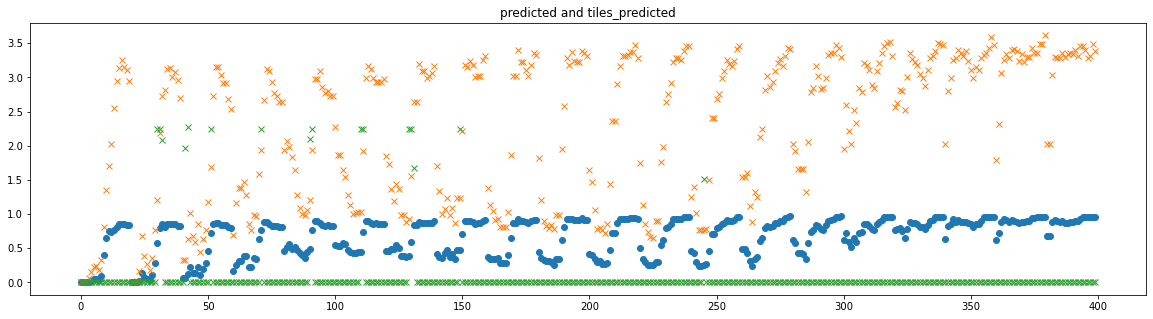

In [24]:
plt.rcParams['figure.figsize'] = [20, 5]

f1 = a_map[:,:,0].reshape(20*20)
f2 = map1[:,:,0].reshape(20*20)
f3 = map2[:,:,0].reshape(20*20)

f1 = f1.tolist()
f2 = f2.tolist()
f3 = f3.tolist()

plt.plot(f1,'o')
plt.plot(f2,'x')
plt.plot(f3,'x')
title('predicted and tiles_predicted')